# __ML/MM & QM/MM calculation analysis__
Once the calculations have finished, select the corresponding `.csv` file containing any energy profile to be plotted and copy them to the `analysis` base directory. It is a good idea to save every `.csv` with a descriptive name (the frame number), as it will be used when plotting. 

This notebook is designed to quickly:
- Analyze CSV files, to obtain the approximate $\Delta E^\ddag$, $\Delta E$, highest energy frame (suitable for TS search) and QM/MM (or ML/MM) Exponential Average contribution to $\Delta G^{\circ\ddag}$. If needed, the $N$ frames with the most stable highest energy frame/node are returned, useful for selecting for which frames to compute the TS (directed approach). 
- Plot a set of CSV files to a single plot. 

### __General imports and analysis functions__

In [ ]:
# general imports
import numpy as np

# plotting
# ! a TEX installation is required !
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

# constants
R = 8.31446261815324
T = 300

# utilities
def read_qmmm_csv(csv):
    '''
    reads the csv output from a ChemShell QM/MM scan calculation. Returns each column as a list. 

    CSV Header: j, rc, E, deltaE, d_CH, d_HOcof, rc_m
    '''

    # read the data in the csv
    csv_data = np.genfromtxt(csv, delimiter=',').T[:,1:]

    # asign data to a corresponding file
    j_list = csv_data[0]
    rc_list = csv_data[1]
    E_list = csv_data[2]
    deltaE_list = csv_data[3]
    d_CH_list = csv_data[4]
    d_HOcof_list = csv_data[5]
    rc_m_list = csv_data[6]

    return j_list, rc_list, E_list, deltaE_list, d_CH_list, d_HOcof_list, rc_m_list


def read_mlmm_csv(csv):
    '''
    reads the csv output from a ML/MM GSM calculation. Returns each column as a list. 

    CSV Header: frame, E, deltaE
    '''

    # read the data in the csv
    csv_data = np.genfromtxt(csv, delimiter=',').T[:,1:]

    # asign data to a corresponding file
    frame_list = csv_data[0]
    E_list = csv_data[1]
    deltaE_list = csv_data[2]

    return frame_list, E_list, deltaE_list


def analyze_E_scans(calculation_type, txt_name, csv_list=[], lowest_N=1):
    '''
    Description
    -----------
    Analyzes the scans to obtain Delta E and Delta E^\ddag of the profile. Stores it in a .txt file. 

    Parameters
    ----------
    calculation_type : 'qmmm' or 'mlmm'
    txt_name : output txt name
    csv_list : a list of strings containing paths to csv files to analyze. 

    '''

    # create data file
    if txt_name != '':
        with open(txt_name+'_readable.txt', 'w') as f:
            pass
        with open(txt_name+'.txt', 'w') as f:
            f.write('# FRAME'.ljust(15)+'Delta Eddag'.ljust(15)+'Delta E'.ljust(15)+'\n')

    
    # save highest energy node for Exponential Average constribution to Delta_G_qmmm. 
    TS_energy_list = []

    for csv in csv_list:

        # extract csv data
        deltaE_reactant_list = []
        if calculation_type == 'qmmm':
            _, rc_list, E_list, deltaE_list, d_CH_list, d_HOcof_list, rc_m_list = read_qmmm_csv(csv)

            # get reactant-like part of the scan
            for j in range(len(rc_list)):
                if rc_list[j] < 0:
                    deltaE_reactant_list.append(deltaE_list[j])

        elif calculation_type == 'mlmm':
            frame_list, E_list, deltaE_list = read_mlmm_csv(csv)

            # get reactant_like part of the san
            for j in range(len(frame_list)):
                if frame_list[j] < round(len(frame_list)/2):
                    deltaE_reactant_list.append(deltaE_list[j])

        else:
            raise ValueError('calculation must be "qmmm" or "mlmm"!')
        E_list_Hartree = E_list / 627.509



        max_index = np.argmax(E_list_Hartree)
        min_index = np.argmin(E_list_Hartree)
        reactant_minimum = np.argmin(deltaE_reactant_list)
        
        # get Delta E \ddag
        deltaE_ddag = deltaE_list[max_index] - deltaE_list[reactant_minimum] 
        TS_energy_list.append(deltaE_ddag)

        # get Delta E
        deltaE = deltaE_list[min_index] - deltaE_list[reactant_minimum]

        # output to file
        if txt_name != '':
            with open(txt_name+'_readable.txt', 'a') as f:
                f.write(f'{csv}\n')
                f.write(f'Max energy frame:'.ljust(20)+f'{max_index+1}\n')
                #f.write(f'Lowest energy reactant:\t{_delta_E[reactant_minimum]}\n')
                #print(f'QM/MM energy (max):  \t{_energy_hartree[max_index]:.6f}\tHartree')
                #print(r'\Delta E\ddag'+f':        \t{_delta_E[max_index]:.3f}       \tkcal/mol')
                f.write(r'\Delta E\ddag:'.ljust(20)+f'{deltaE_ddag:.3f}       \tkcal/mol\n')
                #print(f'QM/MM energy (min):  \t{_energy_hartree[max_index]:.6f}\tHartree')
                #print(r'\D'+f'elta E:        \t{_delta_E[min_index]:.3f}       \tkcal/mol')
                f.write(r'\Delta E:'.ljust(19)+f'{deltaE:.3f}       \tkcal/mol\n\n')

            with open(txt_name+'.txt', 'a') as f:
                f.write(csv[:-4].ljust(15)+f'{deltaE_ddag:.3f}'.ljust(15)+f'{deltaE:.3f}\n')


    # print lowest N highest energy frames
    print('Highest energy frames\n')
    print('FRAME\t\tDeltaE^ddag')
    for j in range(len(csv_list)):
        print(f'{csv_list[j][:-4]}\t\t{TS_energy_list[j]:.2f}')
        # TODO. Arange the list of TS_energy_list and display the frames after sorting


    # compute exponential average contribution to Delta G
    n = len(TS_energy_list)
    EA = 0.
    for deltaE in TS_energy_list:
        EA += np.exp((- deltaE * 4.184 * 1000)/(R * T))
    DeltaG_EA = - R * T * np.log(1/n * EA) / (4.184 * 1000)     # in kcal/mol

    with open(txt_name+'_readable.txt', 'a') as f:
        f.write(f'\n# EA contribution to DeltaG from the above scans (kcal/mol)\n')
        f.write(f'{DeltaG_EA:.3f}')


def plot_scan(csv_list, calculation_type, legend_title='scan', qmmm_rc_title='', save_name='scan.png', ):
    '''
    Plot potential energy E vs. Reaction Coordinate. 
    '''

    # color lists
    colors_qmmm = ['deeppink', 'pink', 'darkred', 'lightcoral', 'darkgoldenrod', 'palegoldenrod']
    colors_mlmm = ['darkgreen', 'mediumaquamarine',  'darkblue', 'cornflowerblue', 'darkviolet', 'plum']


    # set plt plot labels
    if calculation_type == 'qmmm':
        x_axis_name = r'$\textnormal{Reaction coordinate}\;'+f'{qmmm_rc_title}'+r'$'
        y_axis_name = r'$\Delta E\;\;(\textnormal{kcal mol}^{-1})$'
    elif calculation_type == 'mlmm':
        x_axis_name = r'$\textnormal{GSM node number (adim)}$'
        y_axis_name = r'$\Delta E\;\;(\textnormal{kcal mol}^{-1})$'
    else:
        raise ValueError('calculation must be "qmmm" or "mlmm"!')

    # obtain energy values
    plot_E_list = []
    plot_rc_list = []

    if calculation_type == 'qmmm':
        for csv in csv_list:
            _, rc_list, E_list, deltaE_list, d_CH_list, d_HOcof_list, rc_m_list = read_qmmm_csv(csv)
            plot_E_list.append(deltaE_list)
            plot_rc_list.append(rc_list)
    else:
        for csv in csv_list:
            _, E_list, deltaE_list = read_mlmm_csv(csv)
            plot_E_list.append(deltaE_list)
        plot_rc_list.append(range(1, len(plot_E_list[0])+1))

    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(4.5, 4))
    ax1 = axes
    ax1.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
    
    for i in range(len(plot_rc_list)):
        ax1.plot(plot_rc_list[i], plot_E_list[i], color=colors_qmmm[i], alpha=0.9, label=r'$\textnormal{' +f'{csv_list[i][:-4]}' + r'}$')

    ax1.set(xlabel=x_axis_name, ylabel=y_axis_name) 
    ax1.legend(loc='lower left', prop={'size': 10}, title=r'$\textsf{'+f'{legend_title}'+r'}$', title_fontsize=10)            
   
    plt.tight_layout()
    plt.savefig(f'{save_name}', dpi=400)
    plt.show(fig)

## __Analyze CSV files__

In [13]:
#
#   QM/MM
#
analyze_E_scans(calculation_type='qmmm', txt_name='qmmm_analysis', csv_list=['5273.csv'])

Highest energy frames

FRAME		DeltaE^ddag
5273		11.16


In [14]:
#
#   ML/MM
#
analyze_E_scans(calculation_type='mlmm', txt_name='mlmm_analysis', csv_list=['gs.csv'])

6
6
6
6
6
6
6
6
6
6
6
6
6
Highest energy frames

FRAME		DeltaE^ddag
gs		26.43


# __Plot the energy profiles__

> It is important to note that while QM/MM scans do follow a specified reaction coordinate, ML/MM calculations for locating the TS use a GSM (GSM-DE) method, thus it does not follow any reaction coordinate and instead a string spanning from reactant to products is grown to explore the transition. As such, QM/MM scans and ML/MM scans cannot be compared one to one. 

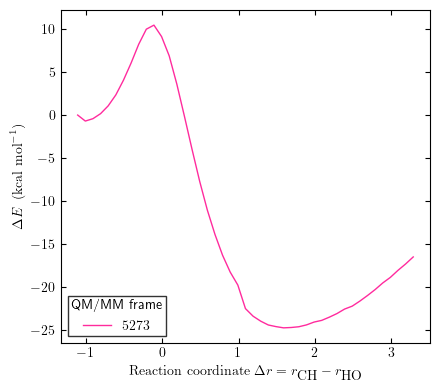

In [4]:
#
#   QM/MM
#
plot_scan(
    csv_list=['5273.csv'],
    calculation_type='qmmm',
    qmmm_rc_title=r'\Delta r = r_{\textnormal{CH}} - r_{\textnormal{HO}}',
    legend_title='QM/MM frame', 
    save_name='analysis_qm.png'
    )

# rc_title=r'\Delta r = r_{\textnormal{CH}} - r_{\textnormal{HO}}'

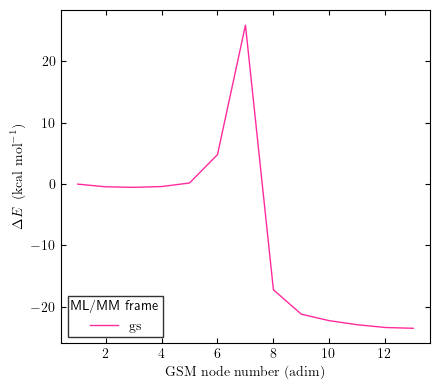

In [2]:
#
#   ML/MM
#
plot_scan(
    csv_list=['gs.csv'],
    calculation_type='mlmm',
    legend_title='ML/MM frame', 
    save_name='analysis_ml.png'
    )